# Consolidating historical urban population density data

In this module I work to use the popular Pandas data science library for Python to ingest, clean, and merge 90 years of decennial historical data. I use modern interpolation techniques to interfill missing data values between decennial counts, and validate with cross references to external databases.

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels.formula.api as sm

## Data Ingest

In [2]:
#initialize the pandas dataframe that will hold all historical data
df_columns = ['city', 'state', 'population', 'square_miles', 'population_density', 'year']
unclean_df = pd.DataFrame(columns = df_columns)
year = 1910  #the data doesn't hold the year inherently so I have to manually count and then interpolate it between decade counts
id = 1  #primary key

#below function iterates over all the files in the directory and appends them to the main pandas DataFrame
for filename in os.listdir('PopulationDensityData'):
    filename = 'PopulationDensityData/' + filename
    file = open(filename, 'r')  #opens the file to read
    
    for line in file:
        line = line.strip()
        row_dict = {}  #make a row dictionary to insert into a df for each line

        population = line[30:42].strip().replace(',','')
        sq_mi = line[41:49].strip().replace(',','')
        comma = line.index(',')
        city = line[4:comma-5].strip()
        state = line[comma+2:comma+4]
        pop_dens = line[line.rfind(' '):].strip().replace(',','')
        
        if id % 100 == 0:
            population = line[31:42].strip().replace(',','')
            sq_mi = line[42:50].strip().replace(',','')
        
        row_dict['city'] = [city]
        row_dict['year'] = [int(year)]
        row_dict['state'] = [state]
        row_dict['population'] = [float(population)]
        row_dict['square_miles'] = [float(sq_mi)]
        row_dict['population_density'] = [float(pop_dens)]
        id += 1
        
        row_df = pd.DataFrame(row_dict)
        unclean_df = unclean_df.append(row_df)
    year += 10  #next file is 10 years later

unclean_df

,city,state,population,square_miles,population_density,year
0,New York,NY,4766883.0,286.8,16621.0,1910
0,Chicago,IL,2185283.0,185.1,11806.0,1910
0,Philadelphia,PA,1549008.0,130.2,11897.0,1910
0,St. Louis,MO,687029.0,61.4,11189.0,1910
0,Boston,MA,670585.0,41.1,16316.0,1910
...,...,...,...,...,...,...
0,Little Rock,AR,175795.0,102.9,1708.0,1990
0,Bakersfield,CA,174820.0,91.8,1904.0,1990
0,Fremont,CA,173339.0,77.0,2251.0,1990
0,Fort Wayne,IN,173072.0,62.7,2760.0,1990


## Data Cleaning - Processing the DataFrame to a usable state for data science

In [3]:
unclean_df = unclean_df.reset_index().drop(columns=['index'])
unclean_df = unclean_df[unclean_df['state'].str.isalpha()]
unclean_df['year'] = pd.to_datetime(unclean_df['year'], format='%Y')

#interpolation time :(
interpolated_df = pd.DataFrame()
def create_interpolated_df(city):
    non_interpolated_df = unclean_df.query(f"city == '{city}'")
    diff_years = non_interpolated_df['year'].max() - non_interpolated_df['year'].min()
    diff_years = int(diff_years.days / 365)
    for yr in range(diff_years):
        if yr % 10 != 0:  #don't want to write over rows that hold the data I need
            calc_year = pd.to_datetime(non_interpolated_df['year'].min().year + yr, format='%Y')
            row_dict = {'year':calc_year,'city':city, 'state':unclean_df[unclean_df['city'] == city]['state'].iloc[0]}
            no_data_years = pd.DataFrame(row_dict, index=[yr])
            non_interpolated_df = non_interpolated_df.append(no_data_years)
    final = non_interpolated_df.sort_values('year')
    final = final.interpolate(method='linear')
    final = final.reset_index().drop(columns=['index'])
    return final

In [4]:
pop_df = pd.DataFrame()
for city in unclean_df['city'].unique():
    city_df = create_interpolated_df(city)
    pop_df = pop_df.append(city_df)
    
pop_df = pop_df.reset_index().drop(columns=['index'])

In [5]:
btp = pd.read_stata('ReplicationData/Breakthrough_Patents.dta')
btp_df = pd.DataFrame(btp)
btp_df = btp_df[['wku', 'filed_year', 'issue_year', 'rank_rrfsim010']].query('filed_year <= 1990 and filed_year >= 1910')

In [6]:
btp_df = btp_df.dropna()
btp_df.head()

,wku,filed_year,issue_year,rank_rrfsim010
21961,22126,1942,1858,0.000016
168062,169003,1975,1875,0.885975
171715,172658,1975,1876,0.792919
171716,172659,1975,1876,0.945290
171930,172874,1976,1876,0.242172


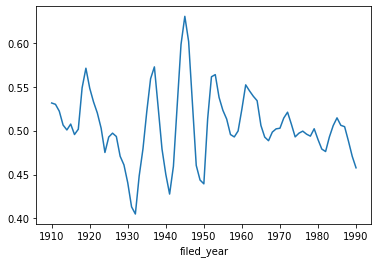

In [7]:
btp_df.groupby('filed_year')['rank_rrfsim010'].mean().plot(x='filed_year', y='rank_rrfsim010')

In [8]:
p_i = pd.read_csv('ReplicationData/patent_inventor.tsv', sep='\t')
pi_df = pd.DataFrame(p_i)

location = pd.read_csv('ReplicationData/location.tsv', sep='\t')
location_df = pd.DataFrame(location)

patent_city_df = location_df.merge(pi_df, how='inner', left_on='id', right_on='location_id')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
patent_city_df = patent_city_df[patent_city_df['country'] == 'US']
patent_city_df.shape

(9443606, 12)

## Exploratory Data Analysis

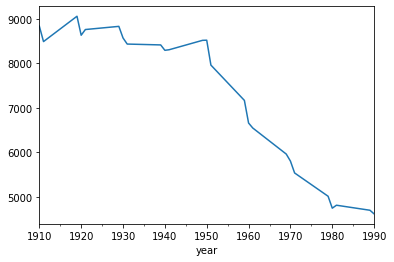

In [10]:
pop_df.groupby('year')['population_density'].mean().plot(x='year', y='population_density')

In [11]:
patent_city_df = patent_city_df.reset_index().drop(columns=['index', 'id'])
patent_city_df.columns

Index(['city', 'state', 'country', 'latitude', 'longitude', 'county',
       'state_fips', 'county_fips', 'patent_id', 'inventor_id', 'location_id'],
      dtype='object')

In [23]:
df = btp_df.merge(patent_city_df, how='inner', left_on='wku', right_on='patent_id')
df['filed_year'] = pd.to_datetime(df['filed_year'], format='%Y')

In [25]:
df.shape

(1118077, 15)

In [26]:
df = df.merge(pop_df, how='inner', left_on=['filed_year', 'city', 'state'], right_on=['year', 'city', 'state'])

In [30]:
df.columns

Index(['wku', 'filed_year', 'issue_year', 'rank_rrfsim010', 'city', 'state',
       'country', 'latitude', 'longitude', 'county', 'state_fips',
       'county_fips', 'patent_id', 'inventor_id', 'location_id', 'population',
       'square_miles', 'population_density', 'year'],
      dtype='object')

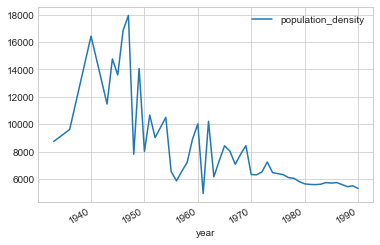

In [59]:
df.groupby('year').mean().plot.line(y=['population_density'])

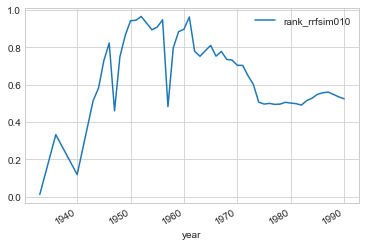

In [58]:
grouped_df = df.groupby('year').mean()
grouped_df.plot(kind='line', y='rank_rrfsim010')

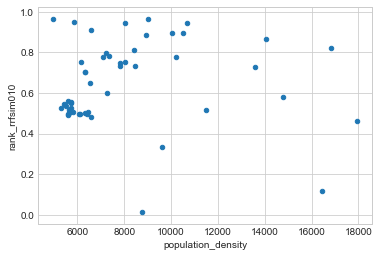

In [60]:
grouped_df.plot(kind='scatter', x='population_density', y='rank_rrfsim010')

In [80]:
result = sm.ols(formula="rank_rrfsim010 ~ population_density + square_miles", data=df).fit()
result.params

Intercept             0.506752
population_density    0.000004
square_miles         -0.000038
dtype: float64

In [81]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rank_rrfsim010   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     441.5
Date:                Sun, 16 Jan 2022   Prob (F-statistic):          5.13e-192
Time:                        18:38:37   Log-Likelihood:                -39222.
No. Observations:              191404   AIC:                         7.845e+04
Df Residuals:                  191401   BIC:                         7.848e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.5068      0.001    371.269      0.000       0.504       0.509
population_density  3.834e-06   1.42e-07     26.948      0.000    3.55e-06    4.11e-06
square_miles       -3.833e-05    4.1e-06     -9.356      0.000   -4.64e-05   -3.03e-05
==============================================================================
Omnibus:                   356419.661   Durbin-Watson:                   1.347
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12796.865
Skew:                           0.045   Prob(JB):                         0.00
Kurtosis:                       1.736   Cond. No.                     1.51e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""